# CS 512 F24: Assignment 3


Due by 10/19/2024

**Name:** Tamilarasee Sethuraj

**Student ID:** A20553416



 # 2. Image Classification

1. Download the Kaggle  Cats and Dogs dataset and select a subset of 2000 dog images and 2000 cat images for training, validation, and testing. The reduced dataset simulates the condition of limited data.
There are two corrupted images in the dataset: 'cat/666.jpg' and 'dog/11702.jpg'. You can delete this two images before selecting the subset. Again, Please DO NOT upload your dataset to the Bitbucket repository.

In [2]:
import numpy as np
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator




Organizing the 2000 images of cats and dogs each into folders of train, test and validation

In [3]:
dataset_path = r'C:\Users\User\Desktop\Desktop files\Fall 2024\CV\CatsandDogs'
train_path = os.path.join(dataset_path,'train')
val_path = os.path.join(dataset_path,'val')
test_path = os.path.join(dataset_path,'test')

In [68]:
for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)
    os.makedirs(os.path.join(path, 'cat'), exist_ok=True)
    os.makedirs(os.path.join(path, 'dog'), exist_ok=True)


def select_and_split_images(class_name, num_images=2000, train_size=0.7):
    src_folder = os.path.join(dataset_path, class_name)
    all_images = os.listdir(src_folder)
    selected_images = random.sample(all_images, num_images)    
   
    train_images, temp_images = train_test_split(selected_images, train_size=train_size, random_state=20)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=20)
    
    for img_list, dest_path in [
        (train_images, os.path.join(train_path, class_name)),
        (val_images, os.path.join(val_path, class_name)),
        (test_images, os.path.join(test_path, class_name))
    ]:
        for img in img_list:
            src_path = os.path.join(src_folder, img)
            dest_file = os.path.join(dest_path, img)
            shutil.copy(src_path, dest_file)
    
    print(f"{class_name.capitalize()} images split: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")


select_and_split_images('cat')
select_and_split_images('dog')


Cat images split: Train=1400, Val=300, Test=300
Dog images split: Train=1400, Val=300, Test=300


Pick the images from train folder and pre-process the images before using it as input to CNN model. The ImageDataGenerator helps to scale the pixel between 0 and 1. The flow from directory helps to look at the subfolders structure and derive the labels appropriately for the images and assigns the subfolder as class 0/1  if the class mode is binary.It also resizes the image to the required input size and seggregate them as batches based on the of batches set. This preprocessing is consistenly followed for train,val and test images. Augmentations are done only to train images.


In [8]:
input_size = (150,150)
batch_size=32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(train_path,target_size=input_size,batch_size=batch_size,class_mode='binary')
val_data = val_datagen.flow_from_directory(val_path,target_size=input_size,batch_size=batch_size,class_mode='binary')

Found 2799 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


2. Build a convolutional neural network (CNN) with several convolution, pooling, and normalization layers, followed by one or more dense layers. Flatten the output between the convolution and dense layers. Evaluate the model's performance on the validation set. 

In [5]:
from keras.layers import Conv2D,Input
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

In [12]:
def create_model(input_size):
    model = models.Sequential()

    model.add(Input(shape=(input_size[0], input_size[1], 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model = create_model(input_size)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,609 (36.49 MB)

 Trainable params: 9,564,161 (36.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])

#early_stopping = tf.keras.callbacks.EarlyStopping(    monitor='val_loss',     patience=5,    mode='min',     restore_best_weights=True)

history = model.fit(
    train_data,
    steps_per_epoch=None,
    epochs=15,
    validation_data=val_data,
    validation_steps=None,
    )


val_loss_no_aug, val_accuracy_no_aug = model.evaluate(val_data)
print(f"Validation accuracy without data augmentation: {val_accuracy_no_aug:.2f}")
print(f"Validation loss without data augmentation: {val_loss_no_aug:.2f}")

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 528s 5s/step - accuracy: 0.6023 - loss: 0.7920 - val_accuracy: 0.5367 - val_loss: 0.6894
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.8271 - loss: 0.3964 - val_accuracy: 0.5017 - val_loss: 0.7677
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9327 - loss: 0.2461 - val_accuracy: 0.5167 - val_loss: 0.7705
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9791 - loss: 0.1681 - val_accuracy: 0.6017 - val_loss: 0.6810
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.9913 - loss: 0.1293 - val_accuracy: 0.6233 - val_loss: 0.7207
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.9980 - loss: 0.0920 - val_accuracy: 0.6883 - val_loss: 0.6306
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.9984 - loss: 0.0735 - val_accuracy: 0.7233 - val_loss: 0.6058
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 1.0000 - loss: 0.0577 - val_accuracy: 0.7200 - v

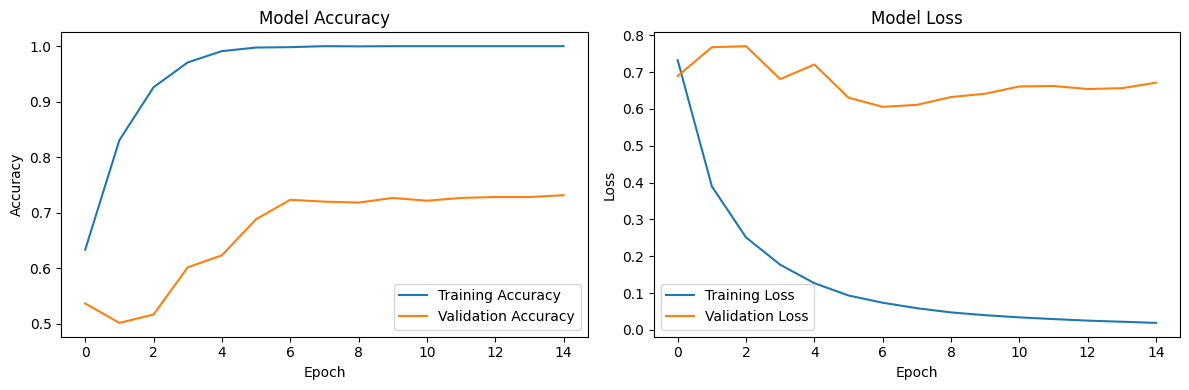

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


3. Modify the data generator to include data augmentation, and evaluate the performance on the validation set again,

In [91]:
input_size = (150,150)
train_datagen_aug = ImageDataGenerator(rescale=1./255,rotation_range = 40,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_data_aug = train_datagen_aug.flow_from_directory(train_path,target_size=input_size,batch_size=20,class_mode='binary')
val_data = val_datagen.flow_from_directory(val_path,target_size=input_size,batch_size=20,class_mode='binary')

Found 2799 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [92]:
model_aug = create_model(input_size)
model_aug.summary()

model_aug.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])

history_aug = model_aug.fit(
    train_data_aug,
    steps_per_epoch=len(train_data_aug) // batch_size,
    epochs=30,
    validation_data=val_data,
    validation_steps=len(val_data) // batch_size)


val_loss_aug, val_accuracy_aug = model_aug.evaluate(val_data)
print(f"Validation accuracy with data augmentation: {val_accuracy_aug:.2f}")
print(f"Validation loss with data augmentation: {val_loss_aug:.2f}")

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,343,617 (12.75 MB)

 Trainable params: 3,343,041 (12.75 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/30


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5303 - loss: 1.0615 - val_accuracy: 0.3000 - val_loss: 0.6945
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 891ms/step - accuracy: 0.4730 - loss: 0.9728 - val_accuracy: 0.2500 - val_loss: 0.7258
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 816ms/step - accuracy: 0.5686 - loss: 0.8716 - val_accuracy: 0.5500 - val_loss: 0.6919
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step - accuracy: 0.6016 - loss: 0.8417 - val_accuracy: 0.5500 - val_loss: 0.6850
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 821ms/step - accuracy: 0.5971 - loss: 0.7725 - val_accuracy: 0.3000 - val_loss: 0.7650
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 808ms/step - accuracy: 0.5373 - loss: 0.8570 - val_accuracy: 0.5000 - val_loss: 0.7014
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5756 - loss: 0.8345 - val_accuracy: 0.6500 - val_loss: 0.6544
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5983 - loss: 0.7710 - val_accuracy: 0.4000 - val_loss: 0.8195
Epoch 9/3

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4500 - val_loss: 0.8069
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7020 - loss: 0.5717 - val_accuracy: 0.5500 - val_loss: 0.7310
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6175 - loss: 0.7143 - val_accuracy: 0.5500 - val_loss: 0.7404
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6694 - loss: 0.6335 - val_accuracy: 0.3500 - val_loss: 0.8687
Epoch 25/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5817 - loss: 0.7451 - val_accuracy: 0.5000 - val_loss: 0.7866
Epoch 26/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5178 - loss: 0.7750 - val_accuracy: 0.5500 - val_loss: 0.7171
Epoch 27/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6023 - loss: 0.7138 - val_accuracy: 0.5500 - val_loss: 0.6903
Epoch 28/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7163 - loss: 0.6303 - val_accuracy: 0.4000 - val_loss: 0.8691
Epo

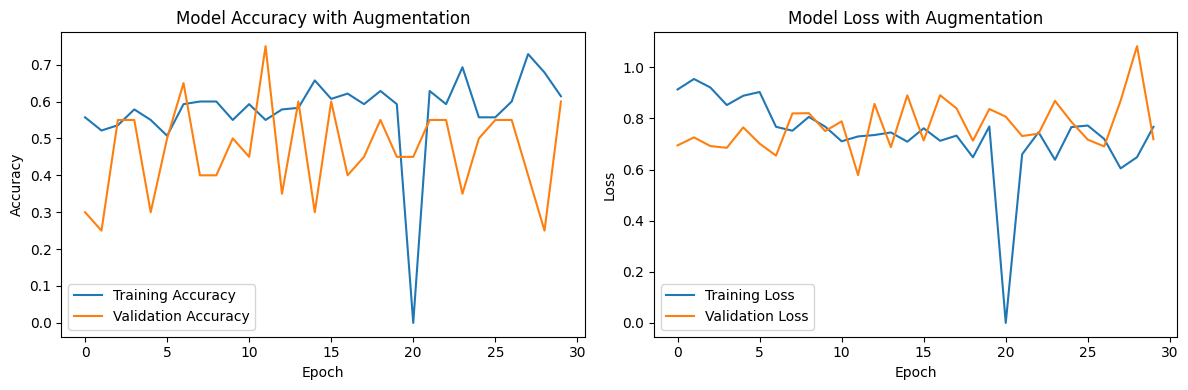

In [93]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'], label='Training Loss')
plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


 4. Replace the convolution layers with a pre-trained VGG16 convolutional base, and evaluate the model's performance on the validation set. 

In [77]:
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D,Input

In [78]:
def create_model_vgg(input_size):
    
    model_vgg16 = models.Sequential()
    model_vgg16.add(Input(shape=input_size))
    
    conv_base = VGG16( weights = 'imagenet', include_top = False, input_shape = (input_size))
    model_vgg16.add(conv_base)
    model_vgg16.add(layers.Flatten())
    model_vgg16.add(layers.Dense(256, activation='relu'))
    model_vgg16.add(layers.Dense(1, activation='sigmoid'))
    
    return model_vgg16,conv_base

input_size = (150,150,3)
model_with_vgg16,conv_base= create_model_vgg(input_size)
model_with_vgg16.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
print('Number of trainable tensors before freezing the conv base from VGG16:',len(model_with_vgg16.trainable_weights))

conv_base.trainable = False
print('Number of trainable tensors after freezing the conv base from VGG16:',len(model_with_vgg16.trainable_weights))

Number of trainable tensors before freezing the conv base from VGG16: 30
Number of trainable tensors after freezing the conv base from VGG16: 4


In [80]:
input_size = (150,150)
train_datagen_aug = ImageDataGenerator(rescale=1./255,rotation_range = 40,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_data_aug = train_datagen_aug.flow_from_directory(train_path,target_size=input_size,batch_size=20,class_mode='binary')
val_data = val_datagen.flow_from_directory(val_path,target_size=input_size,batch_size=20,class_mode='binary')

Found 2799 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [81]:
model_with_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=['accuracy'])

history_with_vgg16 = model_with_vgg16.fit(
    train_data_aug,
    steps_per_epoch=len(train_data_aug) // batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=len(val_data) // batch_size)


val_loss_with_vgg16, val_accuracy_with_vgg16 = model_with_vgg16.evaluate(val_data)
print(f"Validation accuracy with VGG base: {val_accuracy_with_vgg16:.2f}")
print(f"Validation loss with VGG base: {val_loss_with_vgg16:.2f}")

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.4865 - loss: 0.9068 - val_accuracy: 0.7500 - val_loss: 0.5634
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.5527 - loss: 0.6977 - val_accuracy: 0.6000 - val_loss: 0.5449
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.7282 - loss: 0.5890 - val_accuracy: 0.9000 - val_loss: 0.4505
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.6776 - loss: 0.5811 - val_accuracy: 0.8000 - val_loss: 0.3863
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step - accuracy: 0.7227 - loss: 0.5199 - val_accuracy: 0.8500 - val_loss: 0.3267
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.8074 - loss: 0.4548 - val_accuracy: 0.6500 - val_loss: 0.5114
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.7227 - loss: 0.5351 - val_accuracy: 0.9500 - val_loss: 0.2391
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7825 - loss: 0.4516 - val_accuracy: 0.8000 - val_loss: 0.3291
Epoch 9/

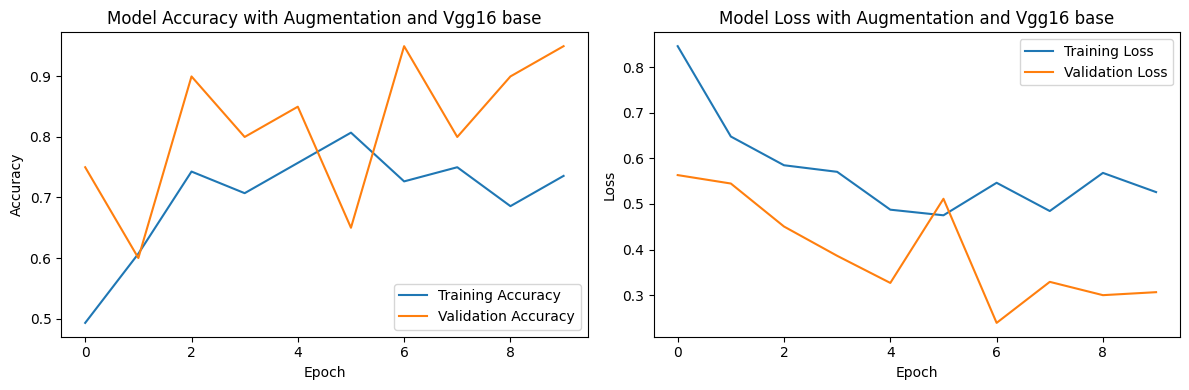

In [82]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_with_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_with_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Augmentation and Vgg16 base')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_with_vgg16.history['loss'], label='Training Loss')
plt.plot(history_with_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Augmentation and Vgg16 base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Unfreeze the conv base and fine tune the model to bring improvement in performance

In [83]:
conv_base.trainable = True
batch_size = 20

for layer in conv_base.layers:
    if layer.name != 'block5_conv1':
        layer.trainable = False
    else:
        print(f"Unfreezing layer: {layer.name}")

model_with_vgg16.compile(loss='binary_crossentropy',
                         optimizer=optimizers.RMSprop(learning_rate=1e-5),
                         metrics=['accuracy'])


history_fine_tuned = model_with_vgg16.fit(
    train_data_aug,
    steps_per_epoch=len(train_data_aug) // batch_size,
    epochs=10,  
    validation_data=val_data,
    validation_steps=len(val_data) // batch_size)


val_loss_finetuned, val_accuracy_finetuned = model_with_vgg16.evaluate(val_data)
print(f"Validation accuracy with Finetuned VGG base model: {val_accuracy_finetuned:.2f}")
print(f"Validation loss with Finetuned VGG base model: {val_loss_finetuned:.2f}")

Unfreezing layer: block5_conv1
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.7215 - loss: 0.5163 - val_accuracy: 0.8500 - val_loss: 0.2929
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8235 - loss: 0.4087 - val_accuracy: 0.9000 - val_loss: 0.2588
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8060 - loss: 0.3936 - val_accuracy: 0.8000 - val_loss: 0.3436
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.7982 - loss: 0.4094 - val_accuracy: 0.7500 - val_loss: 0.4201
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.8206 - loss: 0.4686 - val_accuracy: 0.8500 - val_loss: 0.4029
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8317 - loss: 0.4054 - val_accuracy: 0.7500 - val_loss: 0.4826
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.8467 - loss: 0.4217 - val_accuracy: 0.7500 - val_loss: 0.4497
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8476 - loss: 0.3935 - val_accuracy: 0.8

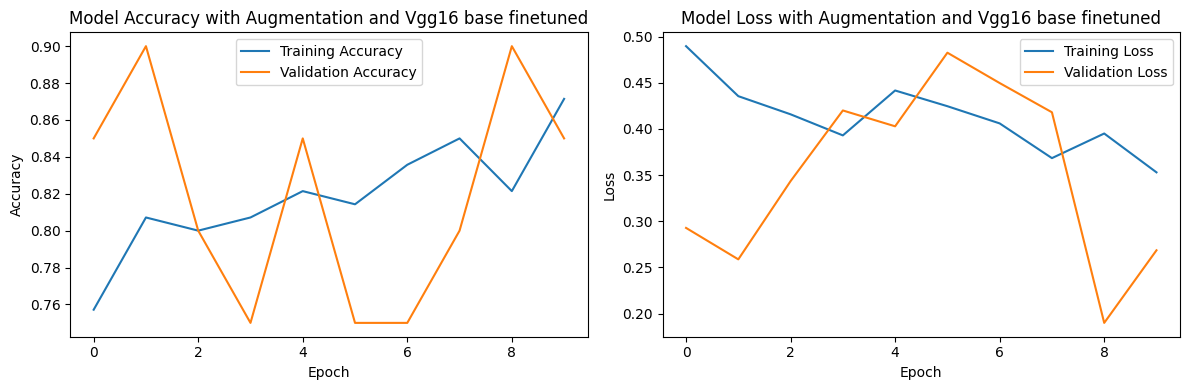

In [84]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Augmentation and Vgg16 base finetuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tuned.history['loss'], label='Training Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Augmentation and Vgg16 base finetuned')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


5. Evaluate the algorithm and report results.The part should be done on the test set.

In [85]:
print("Model Comparison:")
print("-----------------")
print(f"1. Basic CNN (No Augmentation):")
print(f"   Validation Accuracy: {val_accuracy_no_aug:.2f}")
print(f"   Validation Loss: {val_loss_no_aug:.2f}")
print()

print(f"2. CNN with Data Augmentation:")
print(f"   Validation Accuracy: {val_accuracy_aug:.2f}")
print(f"   Validation Loss: {val_loss_aug:.2f}")
print()

print(f"3. VGG16 with Frozen Base:")
print(f"   Validation Accuracy: {val_accuracy_with_vgg16:.2f}")
print(f"   Validation Loss: {val_loss_with_vgg16:.2f}")
print()

print(f"4. VGG16 with Fine-tuned Base:")
print(f"   Validation Accuracy: {val_accuracy_finetuned:.2f}")
print(f"   Validation Loss: {val_loss_finetuned:.2f}")
print()

# Evaluate the final model (fine-tuned VGG16 with augmentation) on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(test_path, target_size=input_size, batch_size=20, class_mode='binary')

test_loss, test_accuracy = model_with_vgg16.evaluate(test_data)
print(f"5. Final Model (Fine-tuned VGG16 with Augmentation) on Test Set:")
print(f"   Test Accuracy: {test_accuracy:.2f}")
print(f"   Test Loss: {test_loss:.2f}")


Model Comparison:
-----------------
1. Basic CNN (No Augmentation):
   Validation Accuracy: 0.50
   Validation Loss: 2.78

2. CNN with Data Augmentation:
   Validation Accuracy: 0.50
   Validation Loss: 2.15

3. VGG16 with Frozen Base:
   Validation Accuracy: 0.80
   Validation Loss: 0.42

4. VGG16 with Fine-tuned Base:
   Validation Accuracy: 0.86
   Validation Loss: 0.30

Found 600 images belonging to 2 classes.
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.8515 - loss: 0.3386
5. Final Model (Fine-tuned VGG16 with Augmentation) on Test Set:
   Test Accuracy: 0.87
   Test Loss: 0.32
